MCS - BeNeFri
<br/>Social Media Analytics, Spring 2020
<br/>Project - Community Detection in a Facebook network
<br/>@authors: Guillaume Chacun, Fabien Vorpe

# Community Detection in a Facebook network

## Dataset

In [1]:
import networkx as nx

In [2]:
edges_filename = 'example.txt'

In [3]:
# Load the Facebook dataset
graph = nx.read_edgelist(f'data/{edges_filename}')

edge_list = ['%i %i {\'weight\': %i}' % (int(d[0]), int(d[1]), int(d[2])) for d in list(graph.edges.data('weight', default=1))]
graph = nx.parse_edgelist(edge_list)

In [4]:
# Explore the properties of the graph

In [5]:
# print number of nodes / edges
print('Number of nodes:', graph.number_of_nodes())
print('Number of edges:', graph.number_of_edges())

Number of nodes: 16
Number of edges: 28


In [6]:
import matplotlib.pyplot as plt
def draw_graph(graph):
    print(graph.edges)
    # visualize network
    options = {
        'node_color': (0,0,1,.6),
        'node_size': 30,
        'line_color': (.8,.8,.8,1),
        'linewidths': 0,
        'width': .1,
        'with_labels': 'True',
    }
    nx.draw_networkx(graph, **options)
    plt.show()

## Algorithms implementation

In [8]:
# Implement the Louvain method for community detection.      
def louvain_passage(graph):
    """
    Performs one passage of Louvain's algorithm to detect communities in a graph.
    :param graph: networkx graph
    :returns: dictionary with graph's nodes as keys and communities' id as values
    """
    m = graph.number_of_nodes()
    prev_communities = {}
    communities = {i: i for i in graph.nodes} # keys: nodes' id, values: nodes' community id
    while list(prev_communities.values()) != list(communities.values()): # while communities are changing
        prev_communities = communities.copy()
        
        communities = {k: v 
                       for k, v in sorted(communities.items(), 
                                          key=lambda item: int(item[1]))} # sort by node id (keys)
        for nodei in communities.keys():
            communityi = communities[nodei]
            #di = len(list(graph.neighbors(nodei)))
            di = sum([graph.get_edge_data(nodei, neighbor)['weight']
                      for neighbor in graph.neighbors(nodei)])
            neighbor_communities = set(communities[neighbor] for neighbor in graph.neighbors(nodei))
            
            # compute modularity gain for each neighbor community of nodei
            modularity_gains = {} # keys: community' id, values: modularity gain
            for communityj in neighbor_communities:
                nodes_in_communityj = [node for node, community in communities.items() 
                                       if community == communityj]
                #dj = sum([len(list(graph.neighbors(node))) 
                #          for node in nodes_in_communityj 
                #          if node != nodei])
                dj = sum([graph.get_edge_data(node, neighbor)['weight'] 
                          for node in nodes_in_communityj
                          for neighbor in graph.neighbors(node) 
                          if node != nodei])
                # count number of neighbors of nodei that are in communityj
                #links_ij = [1 if node in graph.neighbors(nodei) else 0 
                #            for node in nodes_in_communityj]
                links_ij = [graph.get_edge_data(nodei, node)['weight'] if node in graph.neighbors(nodei) else 0 
                            for node in nodes_in_communityj]
                dij = 2 * sum(links_ij)
                # compute modularity
                modularity_gains[communityj] = 1 / (2 * m) * (dij - (di * dj / m))
                
            # update node's community
            modularity_gains = {k: v 
                                for k, v in sorted(modularity_gains.items(), 
                                                   key=lambda item: item[1])} # sort by modularity gain (values)
            communities[nodei] = list(modularity_gains.keys())[-1]
    return communities

In [9]:
def louvain_create_hypernodes(graph, communities):
    """
    Creates the hypernodes graph after one passage of Louvain's aglorithm.
    :param graph: networkx graph
    :param communities: dictionary with graph's nodes as keys and communityies' id as values
    :returns: new networkx graph (communities became hypernodes)
    """
    new_graph = nx.Graph()
    # create hypernodes and reflective edges
    for community in set(communities.values()):
        new_graph.add_node(community)

        # count number of edges in community
        nodes_in_community = [n for n, c in communities.items() if community == c]
        links_intra_community = [1 if neighbor in nodes_in_community else 0 
                                 for node in nodes_in_community
                                 for neighbor in graph.neighbors(node)]
        new_graph.add_edge(community, community, weight=sum(links_intra_community))

    # create inter communities edges
    for community in new_graph.nodes:
        nodes_in_community = [n for n, c in communities.items() if community == c]
        neighbors_of_community = [neighbor
                                  for node in nodes_in_community
                                  for neighbor in graph.neighbors(node) 
                                  if communities[neighbor] != community]
        for other_community in set(communities.values()):
            if other_community != community:
                nodes_in_other_community = [n for n, c in communities.items() if other_community == c]
                nodes_neighbors_in_other_community = [node for node in neighbors_of_community 
                                                      if node in nodes_in_other_community]
                edge_weight = len(nodes_neighbors_in_other_community)
                if other_community not in new_graph.neighbors(community) and edge_weight > 0:
                    new_graph.add_edge(community, other_community, weight=edge_weight)
    return new_graph

In [10]:
def louvain(graph):
    """
    Louvain's algorithm to detect communities in a given graph.
    :param graph: networkx graph
    :returns: graph of communities and a dictionary with graph's nodes as keys and communities' id as values
    """
    all_communities = []
    while len(all_communities) <= 1 or \
            list(all_communities[-2].values()) != list(all_communities[-1].values()): # passage
        communities = louvain_passage(graph)
        graph = louvain_create_hypernodes(graph, communities)
        all_communities.append(communities)
        
        draw_graph(graph)
    return graph, all_communities

In [11]:
# Implement the average clustering coefficient for a graph.
#C(v) = #connected pairs of v's neighbors / #pairs of v's neighbors

## Analysis

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[('12', '12'), ('12', '13'), ('12', '15'), ('13', '13'), ('13', '11'), ('13', '15'), ('13', '10'), ('11', '11'), ('11', '10'), ('15', '15'), ('10', '10')]


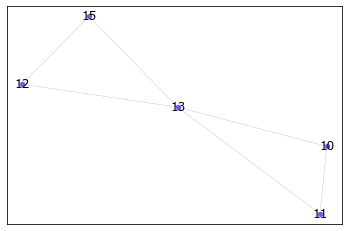

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[('12', '12'), ('12', '13'), ('12', '15'), ('13', '13'), ('13', '11'), ('13', '15'), ('13', '10'), ('11', '11'), ('11', '10'), ('15', '15'), ('10', '10')]


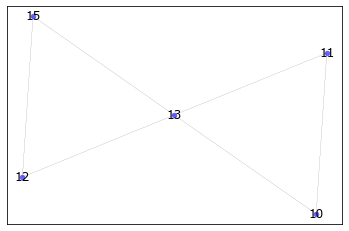

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[('12', '12'), ('12', '13'), ('12', '15'), ('13', '13'), ('13', '11'), ('13', '15'), ('13', '10'), ('11', '11'), ('11', '10'), ('15', '15'), ('10', '10')]


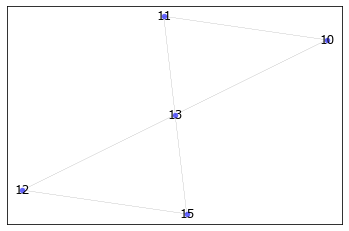

[{'0': '10', '5': '10', '2': '10', '1': '10', '4': '10', '3': '11', '6': '11', '7': '11', '9': '12', '12': '12', '14': '12', '10': '13', '11': '13', '13': '13', '8': '15', '15': '15'}, {'10': '10', '11': '11', '12': '12', '13': '13', '15': '15'}, {'10': '10', '11': '11', '12': '12', '13': '13', '15': '15'}]


In [12]:
# Identify users’ communities in the Facebook network using Louvain
new_graph, communities = louvain(graph)
print(communities)

In [13]:
print(communities)

[{'0': '10', '5': '10', '2': '10', '1': '10', '4': '10', '3': '11', '6': '11', '7': '11', '9': '12', '12': '12', '14': '12', '10': '13', '11': '13', '13': '13', '8': '15', '15': '15'}, {'10': '10', '11': '11', '12': '12', '13': '13', '15': '15'}, {'10': '10', '11': '11', '12': '12', '13': '13', '15': '15'}]


In [14]:
# Identify the top k users with the highest clustering coefficient in the graph.
# Experiment with different values of k and choose the most appropriate one.

In [15]:
# Evaluate different random walk strategies to spread a message across the network.
# The message should reach as many different communities as possible.

## Visualization

In [16]:
# Visualize the output of Louvain by coloring the nodes according to their assigned Communities.

In [17]:
# Visualize the output of applying Random Walk algorithm, by highlighting the sequence of nodes selected in a path.